In [1]:
cd /home

/home


In [41]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import mlflow
import os

from sklearn.metrics import r2_score, mean_squared_error
from src.utils import get_metrics

from presentation.pipelines.steps.model_design import load_pt_model
from presentation.pipelines.steps.load_data import build_loader 


os.environ["CUDA_VISIBLE_DEVICES"] = "1"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pretraining

In [109]:
root = './presentation/results/comparison/2024-03-12_21-32-41/'

astromer, config = load_pt_model(os.path.join(root, 'pretraining'))

[INFO] Using masked-att with alpha = -1000000000.00
[INFO] Using masked-att with alpha = -1000000000.00
[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens


In [110]:
pd.DataFrame(config, index=[0])[['arch', 'mask_format', 'm_alpha', 'probed', 'rs', 'same', 'scheduler']]

,arch,mask_format,m_alpha,probed,rs,same,scheduler
0,base,QK,-1.000000e+09,0.4,0.0,0.0,True


In [111]:
data_path = './data/records/macho/'
loaders = build_loader(data_path, 
                       config, 
                       batch_size=32,
                       clf_mode=False,
                       sampling=True)

[INFO] Probed: 0.40 Random: 0.00 Same: 0.00
[INFO] Repeating dataset x1 times
[INFO] Sampling random windows
[INFO] Loading PT task: Masking
[INFO] Probed: 0.40 Random: 0.00 Same: 0.00
[INFO] Repeating dataset x1 times
[INFO] Sampling random windows
[INFO] Loading PT task: Masking
[INFO] Probed: 0.40 Random: 0.00 Same: 0.00
[INFO] Repeating dataset x1 times
[INFO] Sampling random windows
[INFO] Loading PT task: Masking


In [112]:
output = astromer.predict(loaders['test'].take(10))

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['mask_out'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
10/10 [==============================] - 1s 55ms/step


In [113]:
output['magnitudes'].shape, output['reconstruction'].shape, output['probed_mask'].shape

((320, 200, 1), (320, 200, 1), (320, 200, 1))

In [114]:
y = tf.ragged.boolean_mask(output['magnitudes'], output['probed_mask'])
y_hat = tf.ragged.boolean_mask(output['reconstruction'], output['probed_mask'])

In [115]:
r2_values = []
mse_values = []
for i in range(output['magnitudes'].shape[0]):
    y = tf.boolean_mask(output['magnitudes'][i], output['probed_mask'][i])
    y_hat = tf.boolean_mask(output['reconstruction'][i], output['probed_mask'][i])
    r2_values.append(r2_score(y, y_hat))
    mse_values.append(mean_squared_error(y, y_hat, squared=False))

In [116]:
test_r2   = np.mean(r2_values) 
test_mse = np.mean(mse_values)

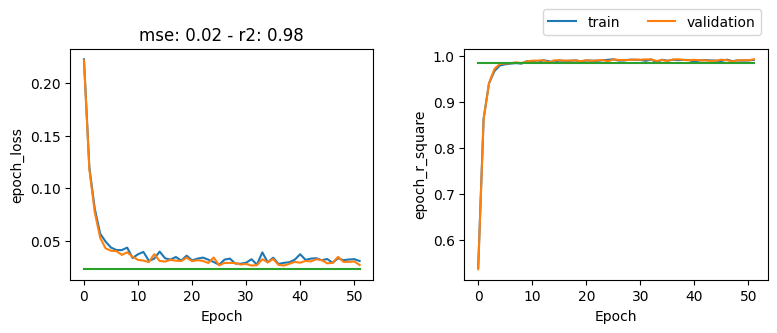

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), gridspec_kw={'wspace':0.3})

for i, metric_name in enumerate(['epoch_loss', 'epoch_r_square']):
    train_metrics = get_metrics(os.path.join(root, 'pretraining', 'tensorboard', 'train'), 
                                metric_name=metric_name)
    valid_metrics = get_metrics(os.path.join(root, 'pretraining', 'tensorboard', 'validation'), 
                                metric_name=metric_name)
    axes[i].plot(train_metrics['step'], train_metrics['value'], label='train')
    axes[i].plot(valid_metrics['step'], valid_metrics['value'], label='validation')
    
    if metric_name == 'epoch_r_square':
        axes[i].plot([0, valid_metrics['step'].iloc[-1]], [test_r2, test_r2])
    if metric_name == 'epoch_loss':
        axes[i].plot([0, valid_metrics['step'].iloc[-1]], [test_mse, test_mse])
        
    axes[i].set_ylabel(metric_name)
    axes[i].set_xlabel('Epoch')
    
axes[0].set_title('mse: {:.2f} - r2: {:.2f}'.format(test_mse, test_r2))
axes[-1].legend(bbox_to_anchor=(1., 1.2), ncols=2)
plt.show()

Text(0.5, 1.0, 'True vs Predicted')

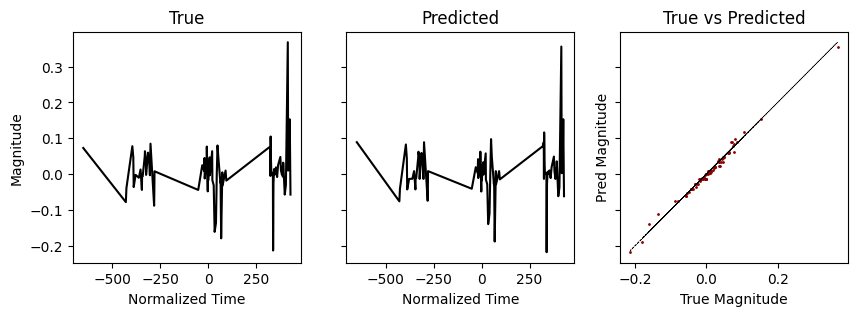

In [123]:
N = 1

x_true = tf.boolean_mask(output['magnitudes'][N], output['probed_mask'][N])
x_pred = tf.boolean_mask(output['reconstruction'][N], output['probed_mask'][N])
times = tf.boolean_mask(output['times'][N], output['probed_mask'][N])

fig, axes = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'wspace':0.2}, sharey=True)
axes[0].plot(times, x_true, color='k', label='True')
axes[0].set_title('True')
axes[0].set_ylabel('Magnitude')
axes[0].set_xlabel('Normalized Time')
axes[1].plot(times, x_pred, color='k', label='Prediction')
axes[1].set_title('Predicted')
axes[1].set_xlabel('Normalized Time')
axes[2].scatter(x_true, x_pred, s=1, color='darkred')
axes[2].plot(x_true, x_true, linewidth=0.5, color='k', linestyle='--')

axes[2].set_xlabel('True Magnitude')
axes[2].set_ylabel('Pred Magnitude')
axes[2].set_title('True vs Predicted')

## Finetunem (MLFlow)

In [136]:
runs_df = mlflow.search_runs(experiment_ids=['128374866685660472'], 
                              search_all_experiments=True)
runs_df = runs_df[runs_df.status == 'FINISHED']

In [138]:
id_cols = ['tags.downstream_data', 'tags.arch', 'tags.m_alpha', 'tags.probed', 'tags.rs', 'tags.same', 'tags.spc']
    
selected = runs_df[id_cols+['tags.fold', 'metrics.val_rmse', 'metrics.test_r2']]

selected.groupby(id_cols).agg({'metrics.val_rmse': ['mean', 'std'],
                                                                          'metrics.test_r2': ['mean', 'std']})

metrics.val_rmse  \
                                                                                                mean   
tags.downstream_data tags.arch tags.m_alpha  tags.probed tags.rs tags.same tags.spc                    
atlas                base      -1000000000.0 0.5         0.0     0.4       100              0.124856   
                                                                           20               0.137506   
macho                base      -1000000000.0 0.5         0.0     0.4       100              0.079102   
                                                                           20               0.053448   
                                                                           500              0.087468   

                                                                                               \
                                                                                          std   
tags.downstream_data tags.arch tags.m_alpha  tags.probed tags.rs tags.same tags.spc             
atlas                base      -1000000000.0 0.5         0.0     0.4       100       0.011952   
                                                                           20        0.011734   
macho                base      -1000000000.0 0.5         0.0     0.4       100       0.014848   
                                                                           20        0.004282   
                                                                           500       0.010329   

                                                                                    metrics.test_r2  \
                                                                                               mean   
tags.downstream_data tags.arch tags.m_alpha  tags.probed tags.rs tags.same tags.spc                   
atlas                base      -1000000000.0 0.5         0.0     0.4       100             0.779488   
                                                                           20              0.759764   
macho                base      -1000000000.0 0.5         0.0     0.4       100             0.863411   
                                                                           20              0.911634   
                                                                           500             0.862703   

                                                                                               
                                                                                          std  
tags.downstream_data tags.arch tags.m_alpha  tags.probed tags.rs tags.same tags.spc            
atlas                base      -1000000000.0 0.5         0.0     0.4       100       0.100562  
                                                                           20        0.063601  
macho                base      -1000000000.0 0.5         0.0     0.4       100       0.059258  
                                                                           20        0.027447  
                                                                           500       0.034494

## Classification (MLFlow)

In [139]:
runs_df = mlflow.search_runs(experiment_ids=['852161655664768094'], 
                              search_all_experiments=True)
runs_df = runs_df[runs_df.status == 'FINISHED']

runs_df = runs_df[['tags.downstream_data', 'tags.arch', 'tags.m_alpha', 
                   'tags.probed', 'tags.rs', 'tags.same', 'tags.spc', 
                   'tags.fold', 'metrics.test_f1']]
runs_df['tags.fold'] = runs_df['tags.fold'].astype(float)
runs_df['metrics.test_f1'] = runs_df['metrics.test_f1'].astype(float)

In [140]:
runs_df.groupby(['tags.downstream_data', 'tags.arch', 'tags.m_alpha', 
                 'tags.probed', 'tags.rs', 'tags.same', 'tags.spc']).agg({'metrics.test_f1': ['mean', 'std']})

metrics.test_f1  \
                                                                                              mean   
tags.downstream_data tags.arch tags.m_alpha tags.probed tags.rs tags.same tags.spc                   
atlas                base      1.0          0.5         0.2     0.8       100             0.565016   
                                                                          20              0.585054   
                                                                          500             0.651385   
macho                base      1.0          0.5         0.2     0.8       100             0.575650   
                                                                          20              0.233617   
                                                                          500             0.618645   

                                                                                              
                                                                                         std  
tags.downstream_data tags.arch tags.m_alpha tags.probed tags.rs tags.same tags.spc            
atlas                base      1.0          0.5         0.2     0.8       100       0.165939  
                                                                          20        0.076211  
                                                                          500       0.052051  
macho                base      1.0          0.5         0.2     0.8       100       0.039289  
                                                                          20        0.274173  
                                                                          500       0.003478